# Starter Notebook for GeneTuring Few-shot Evaluation

Let's start of by implementing a basic harness to evaluate the Geneturing dataset using Ollama with a Few-Shot prompting strategy to evaluate the performance of these models before implementing the tool-using strategies outlined in the GeneGPT paper.

As with most benchmarking code using pretrained models, our notebook will following typical outline of:

1. **Imports**
2. **Configuration**
3. **Data Loading**
4. **Model Specification**
5. **Metrics**
6. **Evaluation Loop**
7. **Analysis**

## 1. Imports

Good hygiene for Jupyter notebooks includes placing all of the imports at the top of the notebook. This makes it easier to understand what dependencies are needed to run the notebook for new users and mirrors good practices for Python scripts.

In [2]:
# 1.1 Place imports here
from typing import List, Optional

from collections import defaultdict
from dataclasses import dataclass

## 2. Configuration

Also, let's create a section that is specific to the configuration of the run. This will make it easier to change the configuration of the run without hunting for hard-coded values sprinkled throughout the code and makes it easier for others to understand the configuration of the run.

We will leave it empty at the moment, but we will come back and fill it in as we identify global configuration options that we need to implement the code.

In [3]:
# 2.1 Data Configuration
@dataclass
class DataConfig:
    input_path: str = "data/geneturing.json"     # 数据输入文件
    output_dir: str = "results/"                 # 结果输出目录
    dataset_format: str = "json"                 # 数据格式
    task_field: str = "question"                 # 输入字段名
    answer_field: str = "answer"                 # 标准答案字段名
    split_key: str | None = None                 # 可选：用于分任务或切分数据

In [4]:
# 2.2 Model Configuration
@dataclass
class ModelConfig:
    model_name: str = "gpt-4"                     # "gpt-4", "gpt-3.5-turbo"
    max_tokens: int = 512
    temperature: float = 0.7
    top_p: float = 0.9
    top_k: Optional[int] = None                   
    use_cuda: bool = False                       
    batch_size: int = 1                        
    model_backend: str = "openai"                 
    model_variant: Optional[str] = None          
    openai_api_key: Optional[str] = None          
    openai_base_url: Optional[str] = "https://api.openai.com/v1"  


In [5]:
# 2.3 Evaluation and Logging Configuration
@dataclass
class EvaluationConfig:
    evaluate_per_task: bool = True              # 是否按任务类型评估（如问答 vs 生成）
    save_failed_cases: bool = True              # 是否保存失败样本
    failed_cases_path: str = "results/failed.json"  # 保存失败样本的位置
    metrics: tuple[str, ...] = ("accuracy",)    # 使用哪些指标，如 accuracy, f1

@dataclass
class LoggingConfig:
    enable_mlflow: bool = True                  # 是否启用 MLflow
    experiment_name: str = "GeneTuring-Run"     # MLflow 实验名
    run_name: Optional[str] = None              # 可选的具体 run 名称
    tracking_uri: Optional[str] = None          # 若设置为 None 则使用默认本地 URI
    log_artifacts: bool = True                  # 是否记录生成文件

## 3. Data Loading

In this section we need to load the data that we will be using for our evaluation. 

The JSON file at `data/gene_turing.json` contains a dictionary of dictionaries. At the top level, the keys are the names of the tasks. Within each task, there are several key-value pairs where the keys are the questions and the values are the answers.

Below is one example for each of the 9 tasks in the dataset:

```json
{
    "Gene alias": {
        "What is the official gene symbol of LMP10?": "PSMB10"
    },
    "Gene disease association": {
        "What are genes related to Hemolytic anemia due to phosphofructokinase deficiency?": "PFKL"
    },
    "Gene location": {
        "Which chromosome is FAM66D gene located on human genome?": "chr8"
    },
    "Human genome DNA aligment": {
        "Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT": "chr15:91950805-91950932",
    },
    "Multi-species DNA aligment": {
        "Which organism does the DNA sequence come from:AGGGGCAGCAAACACCGGGACACACCCATTCGTGCACTAATCAGAAACTTTTTTTTCTCAAATAATTCAAACAATCAAAATTGGTTTTTTCGAGCAAGGTGGGAAATTTTTCGAT": "worm",
    },
    "Gene name conversion": {
        "Convert ENSG00000215251 to official gene symbol.": "FASTKD5",
    },
    "Protein-coding genes": {
        "Is ATP5F1EP2 a protein-coding gene?": "NA",
    },
    "Gene SNP association": {
        "Which gene is SNP rs1217074595 associated with?": "LINC01270",
    },
    "SNP location": {
        "Which chromosome does SNP rs1430464868 locate on human genome?": "chr13",
    }
}
```


We need to reformat this into a pandas dataframe with the following columns:
- `id`: A serial ID number we will assign to each example (int)
- `task`: The name of the task (str)
- `question`: The question for the example (str)
- `answer`: The answer for the example (str)

The final dataframe we will create should look like this:

| id | task | question | answer |
|----|------|----------|--------|
| 0 | Task1 | Question1 | Answer1 |
| 1 | Task1 | Question2 | Answer2 |
| 2 | Task2 | Question1 | Answer1 |
| 3 | Task2 | Question2 | Answer2 |

In [6]:
# 3.1 Load the JSON file

# Load the data here

# Build the TASKS variable here
import json
import pandas as pd
from typing import Dict, Any, List
import os
os.chdir("/project/bioinformatics/WZhang_lab/s440820/Module_3_Yi/project")

def load_and_flatten_gene_turing_data(config: DataConfig) -> pd.DataFrame:
    """
    Loads the nested GeneTuring QA dataset and flattens it into a dataframe.

    Args:
        config (DataConfig): Configuration containing the input file path.

    Returns:
        pd.DataFrame: A dataframe with columns ['task', 'question', 'answer']
    """
    # Step 1: Load raw nested JSON
    with open(config.input_path, "r") as f:
        raw_data: Dict[str, Dict[str, str]] = json.load(f)

    # Step 2: Flatten into list of dicts
    rows: List[Dict[str, Any]] = []
    for task_name, qa_pairs in raw_data.items():
        for question, answer in qa_pairs.items():
            rows.append({
                "task": task_name,
                "question": question,
                "answer": answer
            })

    # Step 3: Convert to DataFrame
    df = pd.DataFrame(rows)[["task", "question", "answer"]]

    return df
data_config = DataConfig(input_path="data/geneturing.json")
df = load_and_flatten_gene_turing_data(data_config)
TASKS = set(df["task"])

print(f"Loaded {len(df)} examples across {len(TASKS)} tasks.")
print("Tasks:", sorted(TASKS))

Loaded 450 examples across 9 tasks.
Tasks: ['Gene SNP association', 'Gene alias', 'Gene disease association', 'Gene location', 'Gene name conversion', 'Human genome DNA aligment', 'Multi-species DNA aligment', 'Protein-coding genes', 'SNP location']


In [7]:
# 3.2 Iterate through the JSON data recursively to collect each of the rows into a list
#     Each row should have a dictionary with keys of the columsn in the table above

In [8]:
# 3.3 Create the pandas dataframe from the collection of rows

## 4. Model Specification

With our few-shot in-context learning model, we need to specify four components:

1. The large language model to use
2. The instructions for the model as a system prompt
3. The few-shot examples to provide to the model to demonstrate the input-output format
4. The completion request function that puts it all together retrieving a response for each unseen input

### 4.1 Setting up the large language model

We will use the Ollama client to interface with the large language model on the Ollama server we started. With large language models, it is common to use a client library to interface with the model hosted by a server. This allows us to iterate quickly on the prompting and post-processing logic without having to incur the overhead of loading the model into memory each time.  Additionally, model code is oftentimes optimized for inference.

In [9]:
# 4.1 Setting up the large language model Ollama model client
import requests
from typing import Optional
from openai import OpenAI
from openai import AzureOpenAI

def query_model(prompt: str, config: ModelConfig) -> Optional[str]:
    """
    Query a large language model using the specified backend (ollama or openai).
    """
    if config.model_backend == "ollama":
        # Using Ollama's local HTTP API
        url = "http://localhost:11434/api/generate"
        payload = {
            "model": config.model_name,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": config.temperature,
                "top_p": config.top_p,
                "top_k": config.top_k,
                "num_predict": config.max_tokens
            }
        }
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json().get("response", "")
        except requests.RequestException as e:
            print(f"[Ollama Error] {e}")
            return None

    elif config.model_backend == "openai":
        # Using OpenAI-compatible API (e.g., local LLM with OpenAI wrapper)
        client = OpenAI(
        api_key=config.openai_api_key
        )
        try:
            response = client.chat.completions.create(
                model=config.model_name,
                messages=[{"role": "user", "content": prompt}],
                temperature=config.temperature,
                top_p=config.top_p,
                max_tokens=config.max_tokens
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"[OpenAI API Error] {e}")
            return None
    elif config.model_backend == "azure":
        client = AzureOpenAI(
            api_key=config.openai_api_key,
            azure_endpoint=config.openai_base_url,
            api_version="2024-03-01-preview"
        )
        try:
            response = client.chat.completions.create(
                model=config.model_name,
                messages=[{"role": "user", "content": prompt}],
                temperature=config.temperature,
                top_p=config.top_p,
                max_tokens=config.max_tokens
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"[Azure API Error] {e}")
            return None

    else:
        raise ValueError(f"Unsupported backend: {config.model_backend}")

In [10]:
model_config = ModelConfig(
    model_name="gpt-4.1",
    model_backend="azure",
    openai_api_key="FJ5GrEV5LG3Y0UIeac29BIhmVu8GPcmWyeTTFH0cBifgT7T68XHPJQQJ99BEACHYHv6XJ3w3AAAAACOGdwHb",
    openai_base_url="https://michaelholcomb-5866-resource.cognitiveservices.azure.com/"
)

output = query_model("What your name? who develop this model?", config=model_config)
print(output)

I'm called ChatGPT, an AI language model developed by OpenAI. My underlying architecture is based on the GPT-4 model, which was created by the research team at OpenAI. If you have any other questions, feel free to ask!


### 4.2 Setting up the system prompt

Modern large language models are post-trained to perform a variety of tasks and follow instructions. To leverage this capability, we need to provide a system prompt that clearly outlines the task, any constraints, and the format of the output.

Designing the system prompt is a critical aspect of using LLMs. Below are several resources for designing a system prompt:
* [OpenAI Prompt Engineering](https://platform.openai.com/docs/guides/text?api-mode=responses#prompt-engineering)
* [Kaggle/Google Prompt Engineering](https://www.kaggle.com/whitepaper-prompt-engineering?_bhlid=a2bfce2cac67662098bd85a241e7cb000576e5d4)
* [Anthropic Prompt Engineering](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/overview)
* [OpenAI GPT 4.1 Prompting Cookbook](https://cookbook.openai.com/examples/gpt4-1_prompting_guide)


**From the OpenAI Prompt Engineering guide:**

> **Identity**: Describe the purpose, communication style, and high-level goals of the assistant. 
> 
> **Instructions**: Provide guidance to the model on how to generate the response you want. What rules should it follow? What should the model do, and what should the model never do? This section could contain many subsections as relevant for your use case, like how the model should call custom functions.  
>
> **Examples**: Provide examples of possible inputs, along with the desired output from the model.  
> 
> **Context**: Give the model any additional information it might need to generate a response, like private/proprietary data outside its training data, or any other data you know will be particularly relevant. This content is usually best positioned near the end of your prompt, as you may include different context for different generation requests.  

This is what the system prompt looked like in the originalGeneGPT paper, but it is not the best. Identify what it includes and what is missing. Implement your own system prompt incorporating best practices from some of the guides posted above. 

> 	'Hello. Your task is to use NCBI Web APIs to answer genomic questions.'

In [11]:
# 4.2 Draft your own system prompt for our generic genomics question answering system. 
#     Replace the system message `content` below with your own.
system_content = """[
You are GeneGPT, an expert genomic assistant designed to answer a wide range of questions about genes, SNPs, chromosomal locations, and related biological knowledge using reliable sources such as NCBI databases.
'You can call Eutils by: "[https://eutils.ncbi.nlm.nih.gov/entrez/eutils/{esearch|efetch|esummary}.fcgi?db={gene|snp|omim}&retmax={}&{term|id}={term|id}]".\n' \
    'esearch: input is a search term and output is database id(s).\n' \
    'efectch/esummary: input is database id(s) and output is full records or summaries that contain name, chromosome location, and other information.\n' \
    'Normally, you need to first call esearch to get the database id(s) of the search term, and then call efectch/esummary to get the information with the database id(s).\n' \
    'Database: gene is for genes, snp is for SNPs, and omim is for genetic diseases.\n\n' \
    'For DNA sequences, you can use BLAST by: "[https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi?CMD={Put|Get}&PROGRAM=blastn&MEGABLAST=on&DATABASE=nt&FORMAT_TYPE={XML|Text}&QUERY={sequence}&HITLIST_SIZE={max_hit_size}]".\n' \
    'BLAST maps a specific DNA {sequence} to its chromosome location among different specices.\n' \
## Instructions:
- Always answer using short and precise scientific terminology.
- If the answer is not available or uncertain, reply with "NA".
- Do not provide explanations unless explicitly asked.
- Only return the exact answer string, without additional commentary or punctuation.
- Respect formatting constraints provided in examples (e.g., "chr13" for chromosomes, official gene symbols like "PSMB10").
- you can also use web search to get the answer if you need.

## Examples:
Q: What is the official gene symbol of LMP10?
A: PSMB10

Q: Which chromosome does SNP rs1430464868 locate on human genome?
A: chr13

## Context:
You are responding as part of an automated system for benchmarking LLM performance on structured genomic queries.
]"""

system_message = [
    {
        "role": "system",
        "content": system_content
    }
]

### 4.3 Setting up the few-shot examples

For tasks with idiosyncratic output formats or constraints, it is important to provide clear instructions as well as examples to guide the model in generating the desired output. Mechanically, we provide these pairs of inputs and outputs as a sequence of user and assistant messages after the system prompt.

```python
messages += [
    {
        "role": "user",
        "content":  <fill in input example 1>
    },
    {
        "role": "assistant",
        "content": <fill in output example 1>
    },
    {
        "role": "user",
        "content": <fill in input example 2>
    },
    {
        "role": "assistant",
        "content": <fill in output example 2>
    }
]
```

In the GeneGPT code, the authors included several tasks, one of each of a subset of the tasks in the dataset. We will use the same examples here.

Please inspect the GeneGPT repository to find the few-shot examples in the prompt. 

Specifically the `get_prompt_header` function in `main.py` located here: [main.py](https://github.com/ncbi/GeneGPT/blob/main/main.py)

In [12]:
# 4.3 Appending the few-shot examples to the `messages` list
import time
import urllib
import re
def call(url):
    time.sleep(1)
    url = url.replace(' ', '+')
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as resp:
        call = resp.read()
    return call

def format_call(url):
    return f'[{url}]->[{call(url)}]\n'

a6_url = 'https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi?CMD=Put&PROGRAM=blastn&MEGABLAST=on&DATABASE=nt&FORMAT_TYPE=XML&QUERY=ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT&HITLIST_SIZE=5'
a6 = call(a6_url)
a6 = re.search('RID = (.*)\n', a6.decode('utf-8')).group(1)

example_messages = [
    {
        "role": "system",
        "content": 'Here are a few examples. Make sure to give results in this format only:\n'
                    + 'Question: Which gene is SNP rs1217074595 associated with?\n' 
                    + format_call('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=gene&retmax=5&retmode=json&sort=relevance&term=LMP10')
                    + format_call('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=gene&retmax=5&retmode=json&id=19171,5699,8138')
                    + 'Answer: PSMB10\n\n'
    },
    {
        "role": "system",
        "content": 'Question: Which gene is SNP rs1217074595 associated with?\n'
                    + format_call('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=snp&retmax=10&retmode=json&id=1217074595')
                    + 'Answer: LINC01270\n\n'
    },
    {
        "role": "system",
        "content": 'Question: What are genes related to Meesmann corneal dystrophy?\n'
                    + format_call('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=omim&retmax=20&retmode=json&sort=relevance&term=Meesmann+corneal+dystrophy')
                    + format_call('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=omim&retmax=20&retmode=json&id=618767,601687,300778,148043,122100')
                    + 'Answer: KRT12, KRT3\n\n'
    },
    {
        "role": "user",
        "content": 'Question: Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT\n'
                    + f'[{a6_url}]->[{a6}]\n'
                    + format_call(f'https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi?CMD=Get&FORMAT_TYPE=Text&RID={a6}')
                    + 'Answer: chr15:91950805-91950932\n\n'
    },
]

example_messages = [
    {
        "role": "user",
        "content": "What is the official gene symbol of LMP10?"
    },
    {
        "role": "assistant",
        "content": "PSMB10\n\n."
    },
    {
        "role": "user",
        "content": "Which chromosome is FAM66D gene located on human genome?"
    },
    {
        "role": "assistant",
        "content": "chr8\n\n."
    }
]

example_messages += [
    {
        "role": "user",
        "content": "Which chromosome does SNP rs1430464868 locate on human genome?"
    },
    {
        "role": "assistant",
        "content": "chr13\n\n."
    }
]



### 4.4 Implementing the model request function

Now we need to put it all together. We need a function that accepts as arguments:
1. The client
2. The system message
3. The few-shot examples
4. The new user query -- this case the user's question from the GeneTuring dataset.

The function should return the response from the model and extract the answer (everything after 'Answer :' based on the format of the examples above)



In [13]:
# 4.4 Implement THE model function
def query_gene_gpt_model(
    client: OpenAI,
    system_prompt: str,
    example_messages: List[Dict[str, str]],
    user_query: str,
    config: ModelConfig
) -> str:
    """
    Query a language model with a system prompt, few-shot examples, and a new user query.

    Args:
        client (OpenAI): The OpenAI client object.
        system_prompt (str): The system-level instruction prompt.
        example_messages (List[Dict]): List of {'role': ..., 'content': ...} example messages.
        user_query (str): The user's question.
        model_name (str): The model name to query.

    Returns:
        str: The extracted answer string.
    """

    # 1. Construct the full message list
    messages = [{"role": "system", "content": system_prompt}]
    messages.extend(example_messages)
    messages.append({"role": "user", "content": user_query})

    # 2. Call the model
    client = AzureOpenAI(
            api_key=config.openai_api_key,
            azure_endpoint=config.openai_base_url,
            api_version="2024-03-01-preview"
        )
    
    response = client.chat.completions.create(
        model=config.model_name,
        messages=messages,
        temperature=config.temperature,
        top_p=config.top_p,
        max_tokens=config.max_tokens
        )

    

    # 3. Extract the full reply content
    full_reply = response.choices[0].message.content.strip()

    # 4. Extract the part after "Answer:" if present
    if "Answer:" in full_reply:
        return full_reply.split("Answer:")[-1].strip()
    else:
        return full_reply  # fallback if no "Answer:" marker found


In [14]:


answer = query_gene_gpt_model(
    client=AzureOpenAI,
    system_prompt="You are a helpful assistant answering genomic questions using NCBI APIs.",
    example_messages=example_messages,  
    user_query="Question: What is the official gene symbol of SNAT6?",
    config=model_config
)

print("Extracted answer:", answer)


Extracted answer: The official gene symbol of SNAT6 is **SLC38A6**.


## 5. Metrics

* **Default exact match** - The predicted answers and ground truth are both strings. The score is 1 if they are equal and 0 otherwise
* **Gene disease association** - The predicted answers and ground truth are both lists of gene-disease associations. The score is the proportion of correct associations present in the prediction
* **Disease gene location** - The predicted and true answers are lists (e.g., gene locations related to a disease), and the evaluation calculates the fraction of the correct items present in the prediction.
* **Human genome DNA aligment** - 1 point for exact match, 0.5 point if chrX part matches, 0 otherwise

In [15]:
def get_answer(answer, task):

	mapper = {'Caenorhabditis elegans': 'worm',
			  'Homo sapiens': 'human',
			  'Danio rerio': 'zebrafish',
			  'Mus musculus': 'mouse',
			  'Saccharomyces cerevisiae': 'yeast',
			  'Rattus norvegicus': 'rat',
			  'Gallus gallus': 'chicken'}

	if task == 'SNP location':
		answer = answer.strip().split()[-1]
		if 'chr' not in answer:
			answer = 'chr' + answer

	elif task == 'Gene location':
		answer = answer.strip().split()[-1]
		if 'chr' not in answer:
			answer = 'chr' + answer

	elif task == 'Gene disease association':
		answer = answer.strip().replace('Answer: ', '')
		answer = answer.split(', ')

	elif task == 'Disease gene location':
		answer = answer.strip().replace('Answer: ', '')
		answer = answer.split(', ')

	elif task == 'Protein-coding genes':
		answer = answer.strip().replace('Answer: ', '')
		if answer == 'Yes':
			answer = 'TRUE'
		elif answer == 'No':
			answer = 'NA'

	elif task == 'Multi-species DNA aligment':
		answer = answer.strip().replace('Answer: ', '')
		answer = mapper.get(answer, answer)

	else:
		answer = answer.strip().replace('Answer: ', '')
	
	return answer

In [16]:
# 5.1 Implement metrics
# 5.1 Implement metrics
from collections import defaultdict
from typing import List, Set, Union, Dict, Callable
import re

def normalize_text(text: str) -> str:
    """Normalize text by converting to lowercase and removing extra whitespace."""
    return text.strip().lower()

def _to_norm_set(items: Union[List[str], str]) -> Set[str]:
    """
    Convert input to a normalized set of strings.
    
    Args:
        items: Either a list of strings or a comma/semicolon-separated string
        
    Returns:
        Set of normalized strings
    """
    if isinstance(items, list):
        tokens = items
    else:
        # Split on both comma and semicolon, handle multiple delimiters
        tokens = re.split(r'[,;]+', items)
    return {normalize_text(tok) for tok in tokens if tok.strip()}

def exact_match(pred: str, true: str) -> float:
    """
    Calculate exact match score between prediction and ground truth.
    
    Args:
        pred: Predicted answer
        true: Ground truth answer
        
    Returns:
        Float score: 1.0 for exact match, 0.0 otherwise
    """
    return float(normalize_text(pred) == normalize_text(true))

def gene_disease_association(pred: Union[List[str], str], true: Union[List[str], str]) -> float:
    """
    Calculate gene-disease association score.
    
    Args:
        pred: Predicted gene-disease associations
        true: Ground truth gene-disease associations
        
    Returns:
        Float score: Proportion of correct associations
    """
    true_set = _to_norm_set(true)
    pred_set = _to_norm_set(pred)
    
    # Handle empty ground truth case
    if not true_set:
        return 1.0 if not pred_set else 0.0
    
    # Calculate intersection over ground truth
    correct = len(true_set & pred_set)
    return correct / len(true_set)

def disease_gene_location(pred: Union[List[str], str], true: Union[List[str], str]) -> float:
    """
    Calculate disease gene location score.
    This is identical to gene-disease association scoring.
    """
    return gene_disease_association(pred, true)

def human_genome_dna_alignment(pred: str, true: str) -> float:
    """
    Calculate human genome DNA alignment score.
    
    Scoring rules:
    - 1.0 for exact match
    - 0.5 if chromosome part matches
    - 0.0 otherwise
    
    Args:
        pred: Predicted alignment
        true: Ground truth alignment
        
    Returns:
        Float score: 1.0, 0.5, or 0.0
    """
    pred_norm = normalize_text(pred)
    true_norm = normalize_text(true)
    
    # Exact match
    if pred_norm == true_norm:
        return 1.0
    
    # Try to extract chromosome parts
    try:
        pred_chr = pred_norm.split(":")[0]
        true_chr = true_norm.split(":")[0]
        return 0.5 if pred_chr == true_chr else 0.0
    except IndexError:
        # If format is invalid, return 0
        return 0.0

# Map task names to their corresponding metric functions
metric_task_map = defaultdict(
    lambda: exact_match,                         # default_factory
    {
        "gene disease association": gene_disease_association,
        "disease gene location": disease_gene_location,
        "human genome dna alignment": human_genome_dna_alignment,
    },
)


Many of the gold-answers are in a specific format. `evaluate.py` also implements an answer post-processing function `get_answer` to better align model outputs with the gold answers. We also need to implement a similar function.

In [17]:
# 5.2 Implement the answer mapping function
def score_answer(pred: str, true: str, task: str) -> float:
    metric = metric_task_map[task.strip().lower()]
    return metric(pred, true)


## 6. Evaluation Loop

Now, let's implement the evaluation loop for the GeneTuring dataset. For now we will call the model function one at a time and collect the results in a list. Also, we will collect per-task metrics and the overall metrics for the dataset as we go. Once we're done, we will save the results to a CSV file.

In [18]:
# 6.1 Set up data structures for results

@dataclass
class Result:
    id: int
    task: str
    question: str
    answer: str
    raw_prediction: Optional[str]
    processed_prediction: Optional[str]
    score: Optional[float]
    success: bool

def save_results(results: List[Result], results_csv_filename: str) -> None:
    raise NotImplementedError



In [19]:
# 6.2 Loop over the dataset with a progress bar

# * Do not forget to add the results to our Result list, both successful and failed predictions
# * API calls will not always work, so make sure we capture the exceptions from failed calls
#    and add them to the Result list with a `status=False`
from tqdm import tqdm
import pandas as pd
from typing import List, Optional
from dataclasses import dataclass
results: List[Result] = []
task_scores: Dict[str, List[float]] = defaultdict(list)
# Create progress bar
for i, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating"):
    try:
        # Get prediction from model
        raw_prediction = query_gene_gpt_model(
            client=OpenAI,
            system_prompt=system_content,  # Using the system content we defined earlier
            example_messages=example_messages,
            user_query=row['question'],
            config=model_config
        )
        
        # Process the prediction using get_answer function
        processed_prediction = get_answer(raw_prediction, row['task'])
        
        # Calculate score using score_answer function
        score = score_answer(processed_prediction, row['answer'], row['task'])

        
        # Create Result object for successful prediction
        result = Result(
            id=i,
            task=row['task'],
            question=row['question'],
            answer=row['answer'],
            raw_prediction=raw_prediction,
            processed_prediction=processed_prediction,
            score=score,
            success=True
        )
        task_scores[row['task']].append(score)
        
    except Exception as e:
        print(f"Error processing example {i}: {str(e)}")
        # Create Result object for failed prediction
        result = Result(
            id=i,
            task=row['task'],
            question=row['question'],
            answer=row['answer'],
            raw_prediction=None,
            processed_prediction=None,
            score=None,
            success=False
        )
    
    # Add result to our list
    results.append(result)
    # Convert results to DataFrame for easier analysis
results_df = pd.DataFrame([vars(r) for r in results])

# Print summary statistics
print(f"\nProcessed {len(results)} examples")
print(f"Successful predictions: {sum(r.success for r in results)}")
print(f"Failed predictions: {sum(not r.success for r in results)}")

    
    
    
    


Evaluating:   0%|          | 0/450 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 450/450 [04:47<00:00,  1.57it/s]


Processed 450 examples
Successful predictions: 450
Failed predictions: 0


In [20]:
print(results[11])

Result(id=11, task='Gene alias', question='What is the official gene symbol of ZNF482?', answer='ZBTB6', raw_prediction='ZNF482', processed_prediction='ZNF482', score=0.0, success=True)


Now, let's implement the evaluation loop for the GeneTuring dataset. For now we will call the model function one at a time and collect the results in a list. Also, we will collect per-task metrics and the overall metrics for the dataset as we go. Once we're done, we will save the results to a CSV file.

In [21]:
# 6.3 Save the results

# 每个任务的平均得分
task_avg = {
    task: sum(scores) / len(scores) if scores else 0.0
    for task, scores in task_scores.items()
}

# 总体平均得分
all_scores = [s for scores in task_scores.values() for s in scores]
overall_avg = sum(all_scores) / len(all_scores) if all_scores else 0.0

# 打印统计
print("\n=== Evaluation Summary ===")
for task, avg in task_avg.items():
    print(f"{task}: {avg:.3f}")
print(f"\nOverall average score: {overall_avg:.3f}")
print(f"Total examples: {len(results)}")
print(f"Successful: {sum(r.success for r in results)}")
print(f"Failed: {sum(not r.success for r in results)}")

# 保存结果
os.makedirs("outputs", exist_ok=True)
results_df.to_csv("outputs/gene_turing_results.csv", index=False)
print("\nResults saved to outputs/gene_turing_results.csv")


=== Evaluation Summary ===
Gene alias: 0.200
Gene disease association: 0.600
Gene location: 0.500
Human genome DNA aligment: 0.000
Multi-species DNA aligment: 0.120
Gene name conversion: 0.000
Protein-coding genes: 1.000
Gene SNP association: 0.000
SNP location: 0.080

Overall average score: 0.278
Total examples: 450
Successful: 450
Failed: 0

Results saved to outputs/gene_turing_results.csv


## 7. Analysis

Now that we have collected the first round of GeneTuring results, let's analyze them. Let's start by calculating what fraction of predictions were successful.

In [22]:
# 7.1 Calculate the fraction of successful predictions
total_predictions = len(results_df)
successful_predictions = results_df['success'].sum()
success_fraction = successful_predictions / total_predictions


Now let's calculate both the overall score as well as the score by task.

In [23]:
# 7.2 Calculate the overall score and the score by task
success_df = results_df[results_df['success'] == True]
overall_score = success_df['score'].mean()
overall_score_by_task = success_df.groupby('task')['score'].mean().sort_values(ascending=False)

Then, let's create a bar chart of the scores by task with a horizontal line for the overall score. Let's save the figure as well to our output directory.

task
Protein-coding genes          1.00
Gene disease association      0.60
Gene location                 0.50
Gene alias                    0.20
Multi-species DNA aligment    0.12
SNP location                  0.08
Gene SNP association          0.00
Gene name conversion          0.00
Human genome DNA aligment     0.00
Name: score, dtype: float64


'outputs/gene_turing_scores_by_task.png'

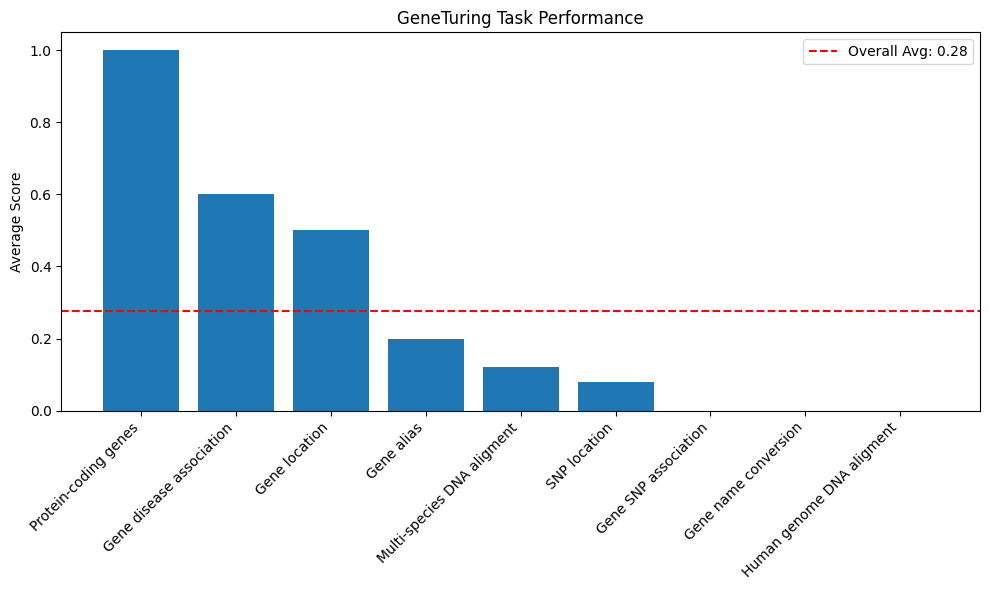

In [24]:
# 7.3 Create a bar chart of the scores by task with a horizontal line for the overall score
import matplotlib.pyplot as plt
import pandas as pd
print(overall_score_by_task)

plt.figure(figsize=(10, 6))
plt.bar(overall_score_by_task.keys(), overall_score_by_task.values)
plt.axhline(y=overall_score, color='red', linestyle='--', label=f'Overall Avg: {overall_score:.2f}')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Score')
plt.title('GeneTuring Task Performance')
plt.legend()
plt.tight_layout()

# 保存图像
os.makedirs("outputs", exist_ok=True)
output_path = 'outputs/gene_turing_scores_by_task.png'
plt.savefig(output_path)

output_path


In [34]:


import mlflow
import os

# 确保输出目录存在
os.makedirs("outputs", exist_ok=True)
# 1. 把 MLflow 服务器加到 NO_PROXY
os.environ["NO_PROXY"] = os.environ.get("NO_PROXY", "") + ",198.215.61.34"
os.environ["no_proxy"] = os.environ["NO_PROXY"]               # 有些系统区分大小写

# 2. 彻底屏蔽代理变量（对当前 Python 进程）
for var in ("http_proxy", "https_proxy", "HTTP_PROXY", "HTTPS_PROXY"):
    os.environ.pop(var, None)
# 设置远程 tracking server
mlflow.set_tracking_uri("http://198.215.61.34:8153/")
mlflow.set_experiment("Yi")

try:
    with mlflow.start_run(run_name="v1-openai"):
        # 参数记录
        mlflow.log_param("model_name", model_config.model_name)
        mlflow.log_param("backend", model_config.model_backend)

        # 分数记录
        mlflow.log_metric("overall_score", overall_avg)
        for task, avg in task_avg.items():
            mlflow.log_metric(f"{task.replace(' ', '_')}_score", avg)

        # 上传文件产物
        mlflow.log_artifact("outputs/gene_turing_scores_by_task.png", artifact_path="figures")
        mlflow.log_artifact("outputs/gene_turing_results.csv", artifact_path="predictions")

except Exception as e:
    print(f"[MLflow Error] Logging failed: {e}")


🏃 View run v1-openai at: http://198.215.61.34:8153/#/experiments/3/runs/15c26a8e8355446cb47f22c5511c0e5a
🧪 View experiment at: http://198.215.61.34:8153/#/experiments/3
